In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
os.chdir(project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("Current dir:", os.getcwd())

Current dir: /Users/ricardojuancardenesperez/tfg/framework


In [2]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

In [ ]:
from playground.readers.EnglishSentencesTextDataset.reader import Reader
from torch.utils.data import DataLoader

from playground.architectures.GRUSeq2seqBidirectional import (
    Builder,
    Wrapper
)

from playground.trainers import TextAnnealingTrainer

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [5]:
dataset = Reader()

In [6]:
for sample in dataset:
    print(sample)
    break

tensor([ 123,  276, 2987, 2019, 1606, 1839, 1375, 1718, 2450, 1421])


In [7]:
pad_idx = dataset.tokenizer.token2idx['<pad>']

In [8]:
def collate_fn(batch, max_len=30):
    global pad_idx
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    
    if batch.size(1) < max_len:
        pad_len = max_len - batch.size(1)
        pad_tensor = torch.full(
            (batch.size(0), pad_len, *batch.shape[2:]),
            fill_value=pad_idx,
            dtype=batch.dtype
        )
        batch = torch.cat([batch, pad_tensor], dim=1)
    
    return batch[:, :max_len]

In [9]:
from functools import partial

loader = DataLoader(dataset, batch_size=32, collate_fn=partial(collate_fn, max_len=30), shuffle=True)

In [10]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([32, 30])


# Model

In [11]:
vocab_size = len(dataset.tokenizer.vocab)

In [12]:
builder = Builder()
model = builder.build(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=64,
    latent_dim=10,
    context_length=30,
    num_layers=1
)

In [13]:
wrapper = Wrapper(model)

In [14]:
x = torch.zeros(1, 12).long()
x, mu, sigma = wrapper(batch)
x.shape

torch.Size([32, 30, 3108])

# Training

In [15]:
criteria = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
trainer = TextAnnealingTrainer(wrapper, 
                      criteria, 
                      optimizer, 
                      epochs=400,
                      batch_size=loader.batch_size,
                      method='logistic',
                      k=0.003,
                      x0=7000)

In [17]:
model, metrics = trainer.train(loader, teacher_forcing=0.5, return_metrics=True)

Epoch: 0, Loss: 798.84326171875, Model Loss: 7.988432635431704, KD Loss: 463.89488419242525, KD Weight: 8.099893627060269e-10
Epoch: 1, Loss: 732.4941777768342, Model Loss: 7.324941821720289, KD Loss: 1054.3650844408119, KD Weight: 8.678519321780135e-10
Epoch: 2, Loss: 642.3934936523438, Model Loss: 6.423934977987538, KD Loss: 1556.4613700534987, KD Weight: 9.298479842572339e-10
Epoch: 3, Loss: 622.0136320694634, Model Loss: 6.22013635220735, KD Loss: 1975.423631751019, KD Weight: 9.962727992706235e-10
Epoch: 4, Loss: 611.2012010657269, Model Loss: 6.112011930216914, KD Loss: 2544.6128088909645, KD Weight: 1.0674427512521573e-09
Epoch: 5, Loss: 602.0341345745584, Model Loss: 6.020341313403586, KD Loss: 3129.614406419837, KD Weight: 1.14369681479728e-09
Epoch: 6, Loss: 593.6747224227241, Model Loss: 5.93674726071565, KD Loss: 3725.06102454144, KD Weight: 1.2253981795613224e-09
Epoch: 7, Loss: 585.914967412534, Model Loss: 5.859149663344674, KD Loss: 4314.396908967391, KD Weight: 1.31293

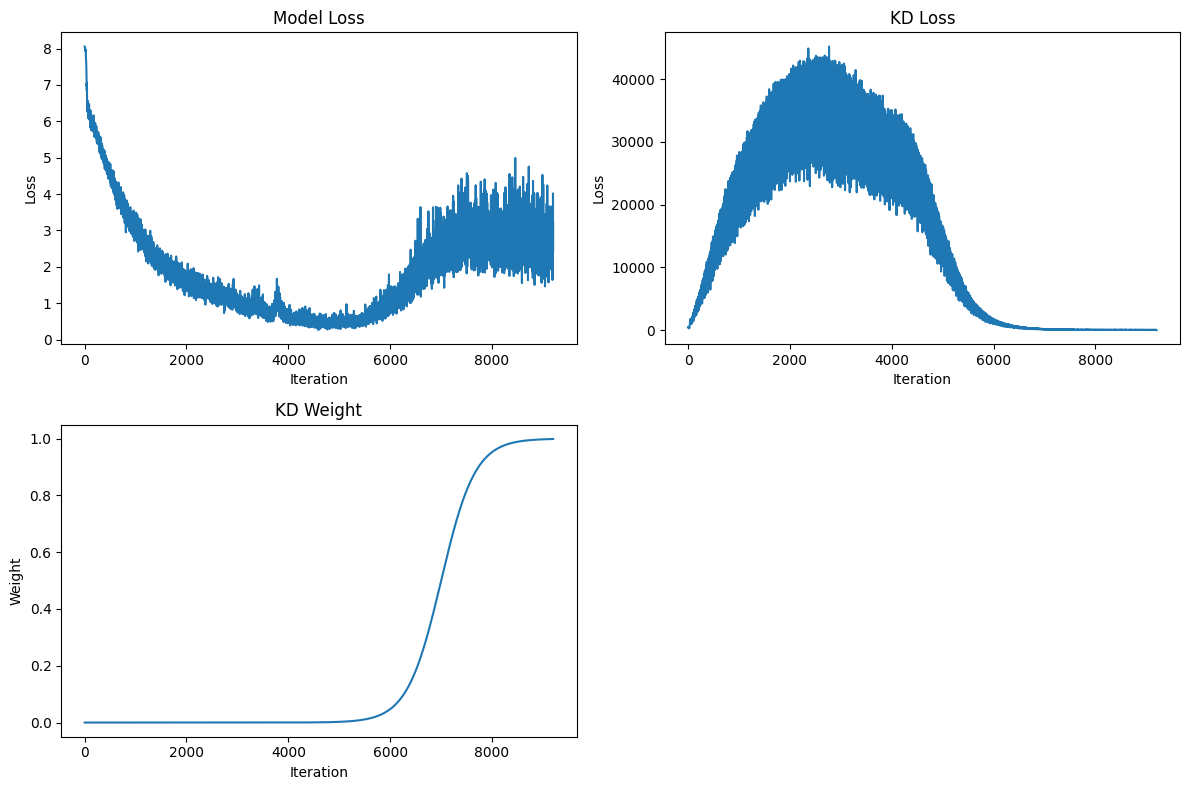

In [18]:
epochs = list(range(1, len(metrics['model_loss']) + 1))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(epochs, metrics['model_loss'])
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(epochs, metrics['kd_loss'])
axes[0, 1].set_title('KD Loss')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')

axes[1, 0].plot(epochs, metrics['kd_weight'])
axes[1, 0].set_title('KD Weight')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Weight')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
with open("experiments/gru_seq2seq_bidirectional_enc_autoreg_dec_english_1_annealing_logistic_cross_entropy_loss_1/metrics.json", "w") as file:
    file.write(str(metrics))

# Performance

In [26]:
def transform_to_text(output):
    return ' '.join(dataset.tokenizer.decode(output.numpy().tolist()[0]))

In [27]:
count = 20
results = {'input': [], 'output': []}

for i, sentence in enumerate(dataset):
    input = sentence.unsqueeze(0)

    output, mu, sigma = model(input)
    output = output.argmax(dim=-1)
    
    input = transform_to_text(input)
    output = transform_to_text(output)

    results['input'].append(input)
    results['output'].append(output)

    print(f"Sample {i}")
    print("Original:", input[:-5])
    print("Reconstructed:", output.split("<eos>")[0])
    print()

    if count == 0:
        break

    count -= 1

Sample 0
Original: The quick brown fox jumps over the lazy dog. 
Reconstructed: know know suit for over for worse told at the 

Sample 1
Original: My Mum tries to be cool by saying that she likes all the same things that I do. 
Reconstructed: She let the balloon float up into the air with her hopes and dreams. 

Sample 2
Original: A purple pig and a green donkey flew a kite in the middle of the night and ended up sunburnt. 
Reconstructed: Nobody ended saw saw saw saw saw the closet. 

Sample 3
Original: Last Friday I saw a spotted striped blue worm shake hands with a legless lizard. 
Reconstructed: days. appeared knew existed. 

Sample 4
Original: A song can make or ruin a person’s day if they let it get to them. 
Reconstructed: what are what a blue eating it blue eating it blue eating it blue eating 

Sample 5
Original: Sometimes it is better to just walk away from things and go back to them later when you’re in a better frame of mind. 
Reconstructed: Malls are great places to shop; I

# Interpolation

In [28]:
z1 = torch.randn(1, 10)
z2 = torch.randn(1, 10)

In [29]:
output1 = model.model.decoder(z1)
output2 = model.model.decoder(z2)

output1 = output1.argmax(dim=-1)
output2 = output2.argmax(dim=-1)

output1 = transform_to_text(output1)
output2 = transform_to_text(output2)

In [30]:
print("First sentence:", output1.split('<eos>')[0])
print("Second sentence:", output2.split('<eos>')[0])

First sentence: The the best part of the sea. 
Second sentence: He is no James Bond; his name be a point. 


In [31]:
num_steps = 10

for alpha in torch.linspace(0, 1, steps=num_steps):
    z_interp = (1 - alpha) * z1 + alpha * z2
    output = model.model.decoder(z_interp)
    output = output.argmax(dim=-1)
    text = transform_to_text(output)
    print(f"alpha={alpha:.2f} →", text.split('<eos>')[0])

alpha=0.00 → The the best part of the sea. 
alpha=0.11 → The the best part of marriage of attire for the 
alpha=0.22 → The was getting a hula hoop can't drink the entire 
alpha=0.33 → The was getting a hula hoop can't drink the 
alpha=0.44 → The was a hula hoop can't to the bathroom drawer. 
alpha=0.56 → There with the chief raccoon with a 
alpha=0.67 → There with the chief raccoon with a 
alpha=0.78 → There with the best way to just happen. 
alpha=0.89 → He is no James Bond; his name is Roger Moore. 
alpha=1.00 → He is no James Bond; his name be a point. 
